In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas_datareader.data as web
from scipy.optimize import minimize

pd.set_option('display.float_format', '{:.10f}'.format)

# Factor Modelling for QQQ Excess Return

In this project we will model QQQ's excess returns against French & Famas factor models. We will use non-robust (OLS) and robust (Huber Loss) regression for each model and compare results.

The Fama French 3 factor model can be defined as:

**Excess Return = α + β1(Rm - Rf) + β2(SMB) + β3(HML) + ε**

Conversely, the Fama French 5 factor model can be defined as:

**Excess Return = α + β1(Rm - Rf) + β2(SMB) + β3(HML) + β4(RMW) + β5(CMA) + ε**

We will also incorporate another factor, the 5 year treasury yield as economic data to see if it bears significance.

## Factor Data

Please find below a brief description of each of the factors, and how their coefficients can be interpreted:

*   **Market Risk Premium (Rm - Rf)** - The Market Risk Premium (MRP) is the extra return investors expect when they choose to invest in the stock market instead of a safe asset like a Treasury bond. Essentially, it’s the difference between the market’s expected return (Rm) and the return on a risk-free asset (Rf). A higher β1​ suggests the stock is more sensitive to market changes, while a lower or negative coefficient would mean the stock isn’t as affected by market shifts.
*   **SMB (Small Minus Big)** - Small minus Big is another factor that refers to the fact that small companies outperform larger companies in the long run. It is the excess return that smaller market capitalization companies return over large cap companies over time. In the Fama-French models, a positive coefficient (β2​) for SMB suggests that a stock performs well when small-cap stocks outperform large-cap stocks in the market. Conversely, a negative coefficient would mean the stock is more aligned with the performance of larger, more established companies.
*   **HML (High Minus Low)** - High minus Low is the third factor in the Fama-French Factor model. It refers to the spread in returns between value stocks and growth stocks. It is based upon the idea that value stocks will tend to outperform growth stocks on average. A positive HML coefficient (β3​) for a stock implies that it benefits when value stocks are performing well relative to growth stocks, suggesting it’s likely aligned with value-oriented characteristics.
*   **RMW (Robust Minus Weak)** - Robust Minus Weak (RMW) is the “profitability factor” in the Fama-French 5-Factor Model, capturing the relationship between a company’s profitability and its stock returns. It is calculated by taking the difference in returns between firms with high (robust) operating profitability and those with low (weak) profitability.  In the Fama-French model, a positive coefficient for RMW (β4​) indicates that the stock performs well when firms with high profitability are outperforming, suggesting the stock may have characteristics of highly profitable companies.
*  **CMA (Conservative Minus Aggressive)** - Conservative Minus Aggressive (CMA) is the “investment factor” in the Fama-French 5-Factor Model, reflecting the relationship between a company’s investment strategy and its stock returns. CMA is calculated as the difference in returns between firms that invest conservatively (low investment) and those that invest aggressively (high investment). A positive CMA coefficient (β5​) implies that the stock performs well in environments where conservatively investing firms are outperforming, suggesting it may share traits with companies that follow low-risk, conservative growth strategies.

We will use daily factor data for the time period 2020-01-01 to 2023-12-31. The data is the 5 factor daily data originated from:

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [30]:
start_date = '2020-01-01'
end_date = '2024-01-01'

data = pd.read_csv('/content/FactorData.csv', index_col = 0)
data.index = pd.to_datetime(data.index, format='%Y%m%d')
data = data[data.index >= start_date]
data = data[data.index <= end_date]
data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,1006.0000000000,1006.0000000000,1006.0000000000,1006.0000000000,1006.0000000000,1006.0000000000
mean,0.0477932406,0.0011729622,0.0053479125,0.0287773360,0.0095924453,0.0065586481
std,1.4838439730,0.8326662898,1.2269411986,0.6852022225,0.6007911309,0.0081900340
min,-12.0000000000,-4.5500000000,-4.9700000000,-2.1800000000,-2.7400000000,0.0000000000
25%,-0.6500000000,-0.5100000000,-0.7000000000,-0.4100000000,-0.3400000000,0.0000000000
50%,0.0700000000,-0.0100000000,-0.0400000000,0.0100000000,-0.0100000000,0.0010000000
75%,0.8000000000,0.4600000000,0.6975000000,0.4800000000,0.3800000000,0.0160000000
max,9.3400000000,5.7200000000,6.7300000000,4.2100000000,2.5200000000,0.0220000000


<Axes: title={'center': 'Factors'}>

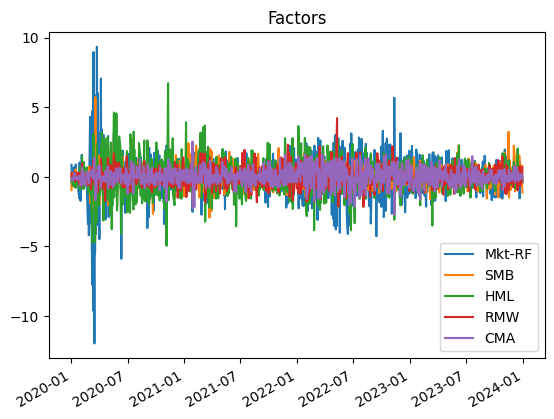

In [31]:
# Drop the 'RF' column and plot the remaining factors
data.drop('RF', axis=1).plot(title='Factors')

In this time period, we have 1006 observations. We can see that all the factor returns hover around 0. Over our time period, we have found that market risk is the factor with the highest mean and standard deviation. This factor is followed by Robust minus weak with the second highest mean and standard deviation.

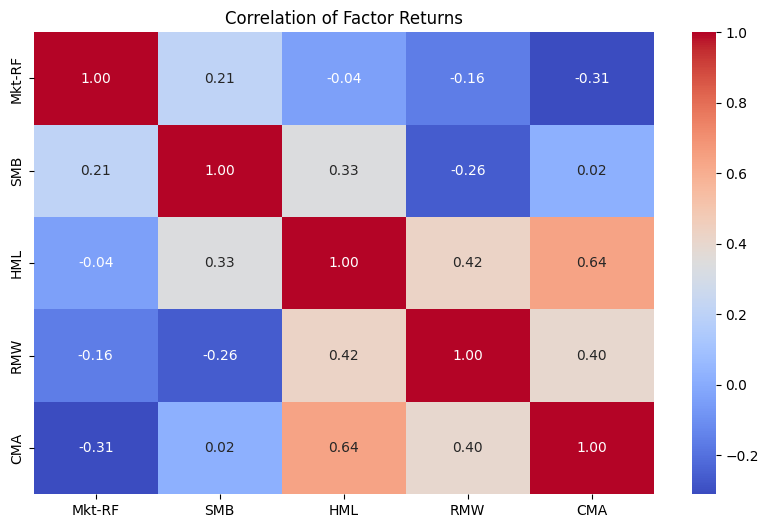

In [8]:
correlation_matrix = data.drop('RF', axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Factor Returns')
plt.show()

From the correlations in factor returns, we can see that CMA and HML have a fairly strong positive correlation of 0.64. Following this, we can see that RMW an HML have the second strongest correlation of 0.42. Interestingly, all of the factors so not seem extremely correlated with Market Risk within this period.

## Economic Data

For our economic data, we will use the Treasury Yield of US 5-year bonds collected from yahoo Finance within the same time period 2020-01-01 to 2023-12-31.

This raw economic data will hopefully prove useful to serve as a 6th factor in our factor modeling in the next steps. The time period between 2020 and 2023 saw a drastic rise in interest rates within the US, which the 5-year bond yield will be able to describe more accurately than the other factors.

In [11]:
df = yf.download("^FVX", start=start_date, end=end_date)
df = df['Adj Close']
df.describe()

[*********************100%***********************]  1 of 1 completed


Ticker,^FVX
count,1006.0000000000
mean,2.1101401572
std,1.5644567271
min,0.1949999928
25%,0.7050000131
50%,1.5519999862
75%,3.7077500224
max,4.9609999657


Text(0.5, 0, 'Date')

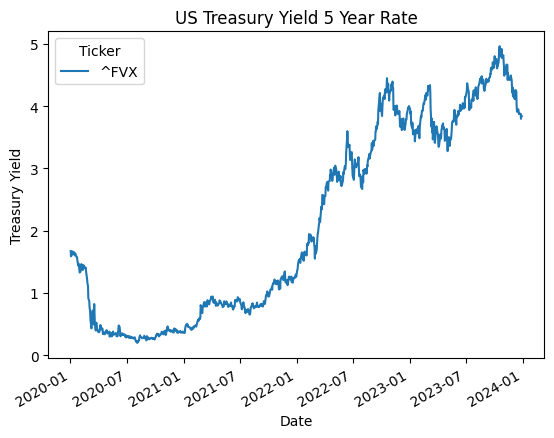

In [12]:
ax = df.plot(title = 'US Treasury Yield 5 Year Rate')
ax.set_ylabel("Treasury Yield")
ax.set_xlabel("Date")

In [15]:
# Merge the economic data into the Factor data as a possible 6th factor

df.index = df.index.date
data = pd.merge(df, data, left_index=True, right_index=True)
data.head()

,^FVX,const,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess_Return
2020-01-03,1.5859999657,1.0000000000,-0.6700000000,0.3000000000,0.0000000000,-0.1300000000,-0.1100000000,0.0060000000,-0.0151601661
2020-01-06,1.6109999418,1.0000000000,0.3600000000,-0.2100000000,-0.5500000000,-0.1700000000,-0.2600000000,0.0060000000,0.0004433717
2020-01-07,1.6189999580,1.0000000000,-0.1900000000,-0.0300000000,-0.2500000000,-0.1300000000,-0.2400000000,0.0060000000,-0.0061390387
2020-01-08,1.6649999619,1.0000000000,0.4700000000,-0.1600000000,-0.6600000000,-0.1600000000,-0.1800000000,0.0060000000,0.0015161311
2020-01-09,1.6549999714,1.0000000000,0.6500000000,-0.7100000000,-0.4800000000,-0.1400000000,0.0400000000,0.0060000000,0.0024734415


## Fama French 3 Factor Model + Economic Data

To run our regression of the FF3 betas, we used data of the Nasdaq 100 index returns within the time period from 2020-01-01 to 2023-12-31. This stock was chosen as it is an indicator of 100 largest non-finacial companies listed on Nasdaq and will be a better choice to train with than any one particular stock. We also incorporated the economic 5 year treasury bond data as a 4th factor to draw insights.


We used a train-test split of 80% training data and 20% testing data, using the scikit learn library. Also add a constant to our feature dataset. We created 2 models OLS and Robust least squares (Huber loss) with dependent variable as excess returns of QQQ and the three Fama-French factors (Mkt-RF, SMB, HML) in addition to US 5-Years Treasury Yield (^FVX) as the independent variables.


In [16]:
# Download QQQ data and calculate daily returns
y = yf.download("QQQ", start=start_date, end=end_date)
y = y['Adj Close'].pct_change()
y.index = y.index.date

# Merge QQQ returns with the data DataFrame on the date index
data = pd.merge(y, data, left_index=True, right_index=True)

# Drop any rows with missing values
data = data.dropna()

# Calculate Excess Return: QQQ returns - RF (risk-free rate)
data['Excess_Return'] = data['QQQ'] - data['RF']

# Drop the QQQ returns column if no longer needed
data = data.drop(columns=['QQQ'])

# ADD CONSTANT
data = sm.add_constant(data)

data.describe()

[*********************100%***********************]  1 of 1 completed


,^FVX,const,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess_Return
count,1005.0000000000,1005.0000000000,1005.0000000000,1005.0000000000,1005.0000000000,1005.0000000000,1005.0000000000,1005.0000000000,1005.0000000000
mean,2.1105771125,1.0000000000,0.0469850746,0.0021393035,0.0056815920,0.0285671642,0.0098208955,0.0065592040,-0.0057509252
std,1.5651742261,0.0000000000,1.4843612268,0.8325162863,1.2275064033,0.6855109305,0.6010465373,0.0081940927,0.0189646295
min,0.1949999928,1.0000000000,-12.0000000000,-4.5500000000,-4.9700000000,-2.1800000000,-2.7400000000,0.0000000000,-0.1257878082
25%,0.7030000091,1.0000000000,-0.6500000000,-0.5100000000,-0.7000000000,-0.4100000000,-0.3400000000,0.0000000000,-0.0184705240
50%,1.5490000248,1.0000000000,0.0700000000,-0.0100000000,-0.0400000000,0.0100000000,-0.0100000000,0.0010000000,-0.0044581358
75%,3.7100000381,1.0000000000,0.8000000000,0.4600000000,0.7000000000,0.4800000000,0.3800000000,0.0160000000,0.0062016831
max,4.9609999657,1.0000000000,9.3400000000,5.7200000000,6.7300000000,4.2100000000,2.5200000000,0.0220000000,0.0787057681


In [17]:
# SPLIT INTO TRAINING AND TEST DATASETS

X_train, X_test, y_train, y_test = train_test_split(
data[['const', 'Mkt-RF',	'SMB',	'HML', '^FVX', 'RMW', 'CMA']], data[['Excess_Return']], train_size=0.8, random_state=42
)

### NON-ROBUST OLS

The results of training our OLS model on the dataset and the betas of the factors are as follows:

In [18]:
# NON ROBUST

# Fit the OLS model
model = sm.OLS(y_train, X_train[['const', 'Mkt-RF',	'SMB',	'HML', '^FVX']]).fit()

# View the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2684.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:15:12   Log-Likelihood:                 3122.6
No. Observations:                 804   AIC:                            -6235.
Df Residuals:                     799   BIC:                            -6212.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.000     11.635      0.0

In [19]:
y_pred = model.predict(X_test[['const', 'Mkt-RF',	'SMB',	'HML', '^FVX']])
r2_score(y_test, y_pred)

0.92816566827765

### ROBUST Huber Loss

For our robust version of regression, we used robust least squares using huber loss offered through the statsmodel package. Running this model against the training dataset bears the following metrics and betas for the factors:

In [20]:
# ROBUST USING HUBER LOSS

robust_model = sm.RLM(y_train, X_train[['const', 'Mkt-RF',	'SMB',	'HML', '^FVX']], M=sm.robust.norms.HuberT())

robust_results = robust_model.fit()

print(robust_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          Excess_Return   No. Observations:                  804
Model:                            RLM   Df Residuals:                      799
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Nov 2024                                         
Time:                        00:15:44                                         
No. Iterations:                    31                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.000     12.708      0.0

In [21]:
ff3_results = pd.DataFrame({
    'FF3 Coefficients': robust_results.params,
    'FF3 p-values': robust_results.pvalues
})

robust_results.params

,0
const,0.0035994146
Mkt-RF,0.0111286129
SMB,-0.0019936652
HML,-0.0030815551
^FVX,-0.0047080433


In [22]:
y_pred = robust_results.predict(X_test[['const', 'Mkt-RF',	'SMB',	'HML', '^FVX']])
r2_score(y_test, y_pred)

0.9268044887431132

## Fama French 5 Factor Model + Economic Data

To run our regression of the FF5 data, we used the same data as before of the excess return of QQQ. We also added the treasury 5-year bond yield as a dummy 6th factor to see if it is of importance.


We used a train-test split of 80% training data and 20% testing data, using the scikit learn library. Also a constant was added to our feature dataset. We create 2 models OLS and Robust least squares (Huber loss) with dependent variable as excess returns of QQQ and the five Fama-French factors (Mkt-RF, SMB, HML, RMW, CMA) in addition to US 5-Years Treasury Yield (^FVX) as the independent variables.


### NON-ROBUST OLS

The results of training our OLS model on the dataset and the betas of the factors are as follows:

In [23]:
# NON ROBUST

# Fit the OLS model
model = sm.OLS(y_train, X_train).fit()

# View the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1830.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:18:56   Log-Likelihood:                 3131.8
No. Observations:                 804   AIC:                            -6250.
Df Residuals:                     797   BIC:                            -6217.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.000     11.469      0.0

In [24]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.9261786824639495

### ROBUST Huber Loss

For our robust version of regression, we used robust least squares using huber loss offered through the statsmodel package. Running this model against the training dataset bears the following metrics and betas for the factors:

In [25]:
# ROBUST USING HUBER LOSS

robust_model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())

robust_results = robust_model.fit()

print(robust_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          Excess_Return   No. Observations:                  804
Model:                            RLM   Df Residuals:                      797
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Nov 2024                                         
Time:                        00:19:27                                         
No. Iterations:                    25                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.000     12.393      0.0

In [26]:
ff5_results = pd.DataFrame({
    'FF5 Coefficients': robust_results.params,
    'FF5 p-values': robust_results.pvalues
})

robust_results.params

,0
const,0.0034798154
Mkt-RF,0.0110532683
SMB,-0.0014466023
HML,-0.0034505877
^FVX,-0.0046797614
RMW,0.0014025302
CMA,-0.0003897345


In [27]:
y_pred = robust_results.predict(X_test)
r2_score(y_test, y_pred)

0.925371383042252

## Comparison of Techniques for Robust Regression

In [28]:
# Merge FF3 and FF5 results side-by-side for comparison
comparison_table = pd.concat([ff3_results, ff5_results], axis=1)

comparison_table

,FF3 Coefficients,FF3 p-values,FF5 Coefficients,FF5 p-values
const,0.0035994146,0.0000000000,0.0034798154,0.0000000000
Mkt-RF,0.0111286129,0.0000000000,0.0110532683,0.0000000000
SMB,-0.0019936652,0.0000000000,-0.0014466023,0.0000000069
HML,-0.0030815551,0.0000000000,-0.0034505877,0.0000000000
^FVX,-0.0047080433,0.0000000000,-0.0046797614,0.0000000000
RMW,NaN,NaN,0.0014025302,0.0000056957
CMA,NaN,NaN,-0.0003897345,0.3279019932


*   The coefficient of Mkt-RF decreases slightly in FF5, however the factor remains highly significant in both models.
*   The coefficient of SMB becomes slightly less negative in case of FF5 model, meaning the size factor has a reduced impact on this model.
^FVX have negative coefficients for both the models and are statistically significant. Negative value indicates that rising interest rates tend to reduce the returns of QQQ. This is in line with general understanding that higher interest rates can negatively impact equity returns, especially for growth stocks and tech-heavy ETF like QQQ. Thus addition of ^FVX captures macroeconomic exposure that could be missed in the traditional factor models.
*   The coefficient of HML remains negative and significant in both the model, which indicates that QQQ has exposure to growth stocks rather than value stocks.
The RMW factor in the FF5 model is statistically significant, which shows that returns of QQQ are influenced by profitability. Positive exposure to RMW indicates that QQQ benefits more from profitable firms than weakly profitable firms.
*   The CMA factor is FF5 model is statistically insignificant, which shows that the investment style (conservative vs aggressive) does not have a meaningful impact on the returns of QQQ.
*   Adding the two extra factors, RMW (Profitability) and CMA (Investment), to the FF3 model provides some additional insight into the returns of QQQ. RMW is significant, indicating that profitable firms contribute positively to the QQQ. However, CMA is not significant, implying that the conservative vs aggressive investment style is not a meaningful predictor for QQQ. The inclusion of RMW slightly adjusts the other factor coefficients but does not alter their significance.
